# Power measurement with Samna only - v0.39.9

## All experiments with network mapped on chip:

### Initialization and connection to the board

In [1]:
import samna
print(f'Samna version {samna.__version__}')

# Open the device and connect it to the power monitor.
xylo_node = samna.device.open_device("XyloAudio3TestBoard")

power_monitor = xylo_node.get_power_monitor()
sink_pm = samna.graph.sink_from(power_monitor.get_source_node())
stopwatch = xylo_node.get_stop_watch()
io = xylo_node.get_io_module()

model = xylo_node.get_model()
source = samna.graph.source_to(model.get_sink_node())

## With the network, clock frequency can not go low as 6.25
clock_frequencies = [6.25, 12.5, 25, 50]
ts = 1e-3


power_measurements_625 = []
power_measurements_125 = []
power_measurements_25 = []
power_measurements_50 = []

Samna version 0.39.9.0


## Create a configuration to map a network on the chip

small == SynNet([24, 24, 24]) 

trained == LIFTorch([63,63,63])

In [3]:
network = "small"

In [4]:
from rockpool.nn.networks import SynNet
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper

xylo_conf = []

if network == "trained":
    from rockpool.nn.modules import LIFTorch
    import warnings
    warnings.filterwarnings("ignore")
    
    ckpt = '../../../docs/devices/xylo-a3/model_sample/to_deploy_inXylo.json'
    
    # - Loading trained model architecture parameters
    arch_params = {'n_classes': 1,
    'n_channels': 16,
    'size_hidden_layers':[63, 63, 63],
    'time_constants_per_layer':[3,7,7],
    'tau_syn_base': 0.02,
    'tau_mem': 0.02,
    'tau_syn_out': 0.02,
    'neuron_model': LIFTorch,
    'dt': 0.00994,
    'output': 'vmem'}
    
    # - Instantiating the model backbone and loading trained checkpoint
    syn_model = SynNet(** arch_params)
    syn_model.load(ckpt)
    
    import rockpool.transform.quantize_methods as q
    
    # getting the model specifications using the mapper function
    spec = mapper(syn_model.as_graph(), weight_dtype='float', threshold_dtype='float', dash_dtype='float')
    # quantizing the model
    spec.update(q.channel_quantize(**spec))
    
    xylo_conf, is_valid, msg = config_from_specification(**spec)
    
elif network == "small":
    from rockpool.transform.quantize_methods import channel_quantize

    net = SynNet(
        n_channels = 16,                        # Number of input channels
        n_classes = 1,                          # Number of output classes (i.e. output channels)
        size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
        time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
    )
    print(net)

    spec = mapper(net.as_graph())
    Q_spec = spec
    Q_spec.update(channel_quantize(**Q_spec))
    xylo_conf, is_valid, msg = config_from_specification(**Q_spec)

    if not is_valid:
        print(msg)

print(xylo_conf)

WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]
WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_linear' with shape (16, 24)
        LIFTorch '0_neurons' with shape (24, 24)
        LinearTorch '1_linear' with shape (24, 24)
        LIFTorch '1_neurons' with shape (24, 24)
        LinearTorch '2_linear' with shape (24, 24)
        LIFTorch '2_neurons' with shape (24, 24)
        LinearTorch 'out_linear' with shape (24, 1)
        LIFTorch 'out_neurons' with shape (1, 1)
    }
}
xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.AcceleratedTime, input_source=InputSource.SpikeEvents, synapse2_enable=0, bias_enable=1, time_resolution_wrap=0, output_counter_wrap=0, enable_hibernation_mode=0, hibernation_mode_time_resolution_wrap=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -127 -84 -36 76 -43 115 -98 -23 101 127 -57 0 107 17 -47 -36 -59 123 -119 -81 -93 -70 -127 -125 98 -127 -42 -30 -56 107 -50 112 -62 -42 -26 6 -40 56 -127 59 -94 1

### Calling `apply_configuration` for mapping network but no digital microphone configuration, no chip activation (i.e., not sending `TriggerProcessing`):


In [7]:
power_consumption = []

for clock in clock_frequencies:
    
    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)
    xylo_node.reset_board_soft(config)
    
    xylo_node.get_model().apply_configuration(xylo_conf)
    xylo_node.get_model().close_ram_access()

    # print("power control 1:", hex(read_register(pwr_ctrl1)))
    # print("power control 2:", hex(read_register(pwr_ctrl2)))
    # print("power control 3:", hex(read_register(pwr_ctrl3)))
    # print("power control 4:", hex(read_register(pwr_ctrl4)))

    pwr_ctrl = [pwr_ctrl1, pwr_ctrl2, pwr_ctrl3, pwr_ctrl4]
    # activate all ram memories
    for add in pwr_ctrl:
        wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
        wwv_ev.address = add
        wwv_ev.data = 0x11111111
        source.write([wwv_ev])

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{power[0]:.1f} mW \tAFE core:\t{power[1]:.1f} mW\tDFE+SNN core:\t{power[2]:.1f} mW')

    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	0.1 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.3 mW
Clock:	12.5 MHz
io:	0.1 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.5 mW
Clock:	25 MHz
io:	0.1 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.9 mW
Clock:	50 MHz
io:	0.3 mW 	AFE core:	0.0 mW	DFE+SNN core:	1.6 mW


### Calling `apply_configuration` for mapping network and digital microphone configuration as in `XyloMonitor` with `RealTime` mode, no chip activation (i.e., not sending `TriggerProcessing`):


In [8]:
power_consumption = []
for clock in clock_frequencies:

    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)
    xylo_node.reset_board_soft(config)


    main_clk_freq = clock * 1e6  # in Hz
    tr_wrap = int(ts * main_clk_freq)

    tr_wrap = 63168
    xylo_conf.operation_mode = samna.xyloAudio3.OperationMode.RealTime
    xylo_conf.digital_frontend.filter_bank.dn_enable = False
    xylo_conf.time_resolution_wrap = tr_wrap
    xylo_conf.debug.always_update_omp_stat = True
    xylo_conf.digital_frontend.filter_bank.use_global_iaf_threshold = False
    xylo_conf.input_source = samna.xyloAudio3.InputSource.DigitalMicrophone
    # - the ideal sdm clock ratio depends on the main clock rate
    # -- int(clock / 1.56 / 2 - 1)
    xylo_conf.debug.sdm_clock_ratio = 24
    xylo_conf.digital_frontend.pdm_preprocessing.clock_direction = 1
    xylo_conf.digital_frontend.pdm_preprocessing.clock_edge = 0
    
    # - Disable internal state monitoring
    xylo_conf.debug.monitor_neuron_v_mem = []
    xylo_conf.debug.monitor_neuron_spike = []
    xylo_conf.debug.monitor_neuron_i_syn = []

    xylo_node.get_model().apply_configuration(xylo_conf)
    xylo_node.get_model().close_ram_access()

    pwr_ctrl = [pwr_ctrl1, pwr_ctrl2, pwr_ctrl3, pwr_ctrl4]
    # activate all ram memories
    for add in pwr_ctrl:
        wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
        wwv_ev.address = add
        wwv_ev.data = 0x11111111
        source.write([wwv_ev])

    # print("power control 1:", hex(read_register(pwr_ctrl1)))
    # print("power control 2:", hex(read_register(pwr_ctrl2)))
    # print("power control 3:", hex(read_register(pwr_ctrl3)))
    # print("power control 4:", hex(read_register(pwr_ctrl4)))

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{power[0]:.1f} mW \tAFE core:\t{power[1]:.1f} mW\tDFE+SNN core:\t{power[2]:.1f} mW')
    
    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	0.1 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.3 mW
Clock:	12.5 MHz
io:	0.1 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.5 mW
Clock:	25 MHz
io:	0.3 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.8 mW
Clock:	50 MHz
io:	0.5 mW 	AFE core:	0.0 mW	DFE+SNN core:	1.5 mW


### Calling `apply_configuration` for mapping network and digital microphone configuration as in `XyloMonitor` with `RealTime` mode, with chip activation (i.e., sending `TriggerProcessing`):


In [9]:
power_consumption = []
for clock in clock_frequencies:

    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)
    xylo_node.reset_board_soft(config)

    main_clk_freq = clock * 1e6  # in Hz
    tr_wrap = int(ts * main_clk_freq)

    tr_wrap = 63168
    
    xylo_conf.operation_mode = samna.xyloAudio3.OperationMode.RealTime
    xylo_conf.digital_frontend.filter_bank.dn_enable = False
    xylo_conf.time_resolution_wrap = tr_wrap
    xylo_conf.debug.always_update_omp_stat = True
    xylo_conf.digital_frontend.filter_bank.use_global_iaf_threshold = False
    xylo_conf.input_source = samna.xyloAudio3.InputSource.DigitalMicrophone
    # - the ideal sdm clock ratio depends on the main clock rate
    # -- int(clock / 1.56 / 2 - 1)
    xylo_conf.debug.sdm_clock_ratio = 24
    xylo_conf.digital_frontend.pdm_preprocessing.clock_direction = 1
    xylo_conf.digital_frontend.pdm_preprocessing.clock_edge = 0
    
    # - Disable internal state monitoring
    xylo_conf.debug.monitor_neuron_v_mem = []
    xylo_conf.debug.monitor_neuron_spike = []
    xylo_conf.debug.monitor_neuron_i_syn = []

    xylo_node.get_model().apply_configuration(xylo_conf)
    xylo_node.get_model().close_ram_access()

    pwr_ctrl = [pwr_ctrl1, pwr_ctrl2, pwr_ctrl3, pwr_ctrl4]
    # activate all ram memories
    for add in pwr_ctrl:
        wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
        wwv_ev.address = add
        wwv_ev.data = 0x11111111
        source.write([wwv_ev])


    # print("power control 1:", hex(read_register(pwr_ctrl1)))
    # print("power control 2:", hex(read_register(pwr_ctrl2)))
    # print("power control 3:", hex(read_register(pwr_ctrl3)))
    # print("power control 4:", hex(read_register(pwr_ctrl4)))

    # Activate the chip processing
    source.write([samna.xyloAudio3.event.TriggerProcessing()])

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{power[0]:.1f} mW \tAFE core:\t{power[1]:.1f} mW\tDFE+SNN core:\t{power[2]:.1f} mW')
    
    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	1.4 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.3 mW
Clock:	12.5 MHz
io:	1.4 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.5 mW
Clock:	25 MHz
io:	1.5 mW 	AFE core:	0.0 mW	DFE+SNN core:	0.9 mW
Clock:	50 MHz
io:	1.8 mW 	AFE core:	0.0 mW	DFE+SNN core:	1.7 mW


### Plot all power consumption together

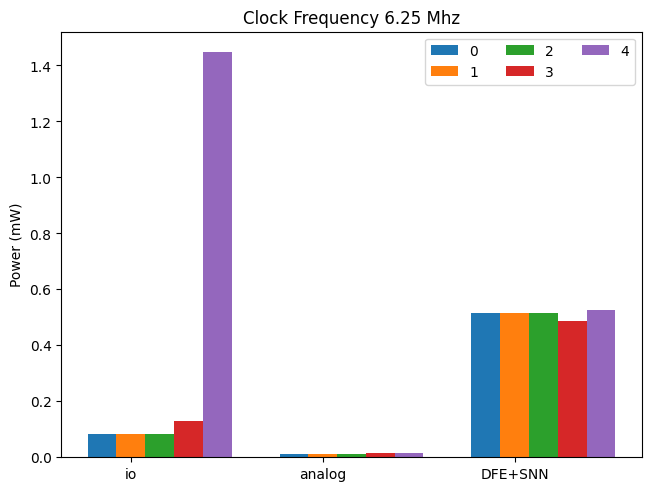

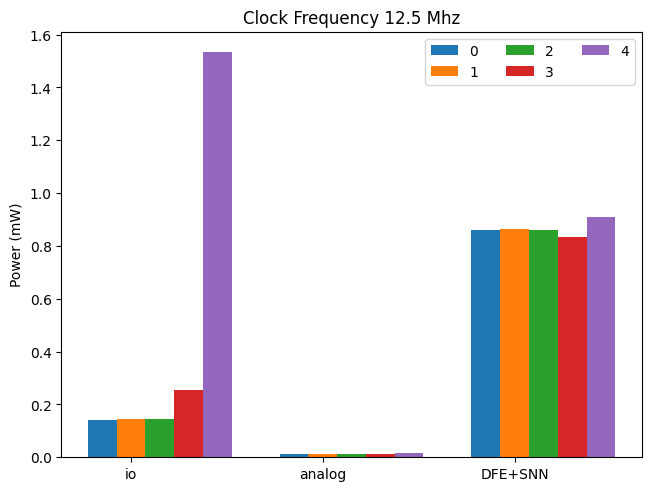

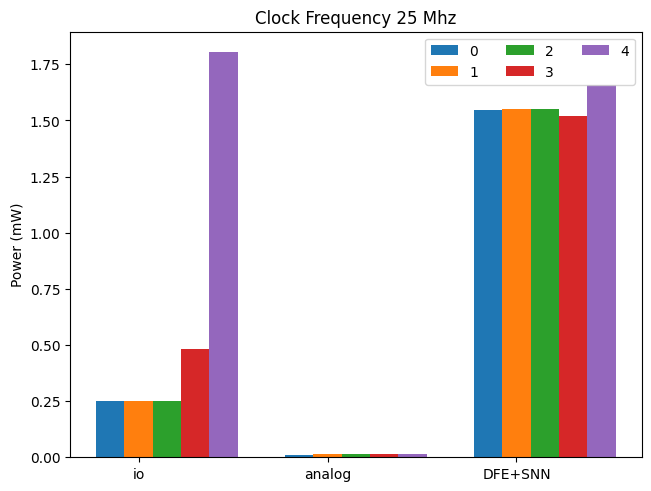

In [10]:
import numpy as np
import matplotlib.pyplot as plt


frequency_measurement = [power_measurements_125, power_measurements_25, power_measurements_50]

for frequency, clock in zip(frequency_measurement, clock_frequencies):
    power_labels = ["io", "analog", "DFE+SNN"]
    
    number_experiment = []
    for i in range(len(frequency)):
        number_experiment.append(i)
        
    x = np.arange(len(power_labels))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')

    for measurement, label in zip(frequency, number_experiment):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=label)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Power (mW)')
    title = "Clock Frequency " + str(clock) + " Mhz"
    ax.set_title(title)
    ax.set_xticks(x + width, power_labels)
    ax.legend(loc='best', ncols=3)
    
    plt.show()

In [2]:
def read_register(addr):
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address = addr)])
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data

ctrl1 = 0x0001
ctrl2 = 0x0002
ctrl3 = 0x0003
tr_wrap = 0x0004
hm_tr_wrap = 0x0005
clk_ctrl = 0x0006
clk_div = 0x0007
pwr_ctrl1 = 0x0008
pwr_ctrl2 = 0x0009
pwr_ctrl3 = 0x000A
pwr_ctrl4 = 0x000B
pad_ctrl = 0x000C
ie1 = 0x000E
ie2 = 0x000F
out_ctrl = 0x0011
monsel = 0x0166
mon_grp_sel = 0x0167
dbg_ctrl1 = 0x0168
dbg_stat1 = 0x0171
dfe_ctrl = 0x001B
ivgen = 0x0015
ivgen2 = 0x0016
ivgen3 = 0x0017
ivgen4 = 0x0018
ivgen5 = 0x0019
ivgen6 = 0x001A
adctest = 0x016E

# create access to xylo input/output
source = samna.graph.source_to(model.get_sink_node())
sink   = samna.graph.sink_from(model.get_source_node())